# General Implementation of Grover Over Entire Search Space (Oracle 2)
---

In [1]:
import networkx as nx
import numpy as np
import math
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import warnings
from random import choice, randint
import os
import re
from functools import reduce
import itertools
import more_itertools as mit
from IPython.display import IFrame
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
import operator as op
from qiskit.tools.visualization import plot_histogram
import csv
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore", category=UserWarning)
S_simulator = Aer.backends(name='statevector_simulator')[0]
M_simulator = Aer.backends(name='qasm_simulator')[0]

In [ ]:
#A function to display results in a ket format (as descripted in arXiv:1903.04359v1)
def Measurement(quantumcircuit, *args, **kwargs): 
	#Displays the measurement results of a quantum circuit 
	p_M = True
	S = 1
	ref = False
	NL = False
	if 'shots' in kwargs:
		S = int(kwargs['shots'])
	if 'return_M' in kwargs:
		ret = kwargs['return_M']
	if 'print_M' in kwargs:
		p_M = kwargs['print_M']
	if 'column' in kwargs:
		NL = kwargs['column']
	M1 = execute(quantumcircuit, M_simulator, shots=S).result().get_counts(quantumcircuit)
	M2 = {}
	k1 = list(M1.keys())
	v1 = list(M1.values())
	for k in np.arange(len(k1)):
		key_list = list(k1[k])
		new_key = ''
		for j in np.arange(len(key_list)):
			new_key = new_key+key_list[len(key_list)-(j+1)]
		M2[new_key] = v1[k]
	if(p_M):
		k2 = list(M2.keys())
		v2 = list(M2.values())
		measurements = ''
		for i in np.arange(len(k2)):
			m_str = str(v2[i])+'|'
			for j in np.arange(len(k2[i])):
				if(k2[i][j] == '0'):
					m_str = m_str + '0' 
				if(k2[i][j] == '1'):
					m_str = m_str + '1'
				if( k2[i][j] == ' ' ):
					m_str = m_str +'>|'
			m_str = m_str + '>   '
			if(NL):
				m_str = m_str + '\n'
			measurements = measurements + m_str
		#print(measurements)
		return measurements
	if(ref):
		return M2

# Get graph from list of edges
---

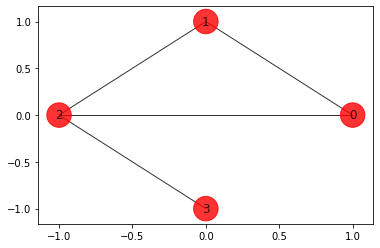

In [2]:
#Produce a graph from a list of edges
#The edges list must be ordered as in, all edges from node 0 then 1 then 2 and so on...
G = nx.Graph()
default_axes = plt.axes(frameon=True)
#4nodes, triangle
edges = [(0, 1), (2, 3), (0, 2), (1, 2)]#The graph we used so far
#8nodes, 4node-clique
#edges = [(0, 1), (2, 3), (0, 2), (1, 2),(0,3),(0,4),(1,3),(3,4),(3,6),(4,6),(4,5),(5,6),(6,7)]
#5nodes, 4 nodes clique
#edges =[(0, 1), (2, 3), (0, 2), (1, 2), (0, 3), (1, 3)]
#edges = [(0,1),(0,3),(1,2),(1,3),(2,4),(2,5),(3,4),(4,5)] #two non-overlapping triangles.
#1- Find number of nodes based on a given list of edges
n_nodes = len(set(itertools.chain.from_iterable(edges))) 
k = 3  #size of clique
#2- Draw graph based on number of nodes and edges
G.add_edges_from(edges)
G.add_nodes_from(range(n_nodes))
G.add_edges_from(edges)
colors = ['r' for node in G.nodes()]
pos = nx.shell_layout(G)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

# Define cz gate
---

In [3]:
def cnz(qc, num_control, node, anc):
    """
    num_control :  number of control qubit of cnz gate
    node :             node qubit
    anc :               ancillaly qubit
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

# The Diff operator
---

In [4]:
def grover_diff(qc, nodes_qubits,edge_anc,edge_flag,node_anc,node_flag,ancilla):
    qc.h( nodes_qubits)
    qc.x( nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x( nodes_qubits)
    qc.h( nodes_qubits)

# The Oracle
---

In [5]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    #print(bin_k)
    #print(qubits)
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    #print(l)
    qc.mct(l,flag_qubit,[anc])

In [6]:
def inc(n): #Quantum increment circuit
    # n >> size of increment circuit
    a = QuantumRegister(n)  
    qc = QuantumCircuit(a,name="inc")
    print(len(a))
    if len(a)==2:
        qc.cx(a[0],a[1])
        qc.x(a[0]) 
    elif len(a)==3:
        qc.ccx(a[0],a[1],a[2])
        qc.cx(a[0],a[1])
        qc.x(a[0]) 
    elif len(a)>3:
        anc = QuantumRegister(1)
        qc.add_register(anc)
        for i in range(len(a)-1,-1,-1):
            if i > 0:
                control_qubits = a[:i]
                qc.mct(control_qubits,a[i],anc[:]) 
            elif i == 0:
                qc.x(a[i])
    else:
        raise Exception("Unvalid Quantum Register!")
    return qc

In [7]:
k = 3 
inc_k = len(bin(k)[2:])
incg = inc(inc_k).to_gate()
incgc = incg.control()
rev = incgc.inverse()

2


In [8]:
def oracle(k,n_nodes, edges, qc, nodes_qubits, edge_anc,edge_flag,node_anc,node_flag, ancilla, neg_base):
    #1- edge counter
    #forward circuit
    qc.barrier()
    needed_qubits = len(bin(k)[2:])
    for i in range(0, len(edges)):
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_flag[0])
        if needed_qubits>3:
            args = [edge_flag[0]]+edge_anc[:]+ancilla[:n-2]
        else:
            args = [edge_flag[0]]+edge_anc[:] 
        qc.append(incgc,qargs=args)
    #----------------------------------------------------------------------------------------------------------
    #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    #print([edge_anc[i] for i in range(len(edge_anc))])
    edge_counter(qc,edge_anc,ancilla[n_nodes-3],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------
    #2- node counter
    #forward circuit
    for i in range(0, n_nodes):
        qc.cx(nodes_qubits[i], node_flag[0])
        if needed_qubits>3:
            args = [node_flag[0]]+node_anc[:]+ancilla[:n-3]
        else:
            args = [node_flag[0]]+node_anc[:] 
        #print(len(args))
        qc.append(incgc,qargs=args)
    #---------------------------------------------------------------------------------------------------------
    #Node check qubit
    edge_counter(qc,node_anc,ancilla[0],neg_base[1], k)
    #---------------------------------------------------------------------------------------------------------
    qc.ccx(neg_base[0],neg_base[1],neg_base[2])
    edge_counter(qc,node_anc,ancilla[0],neg_base[1], k)
    edge_counter(qc,edge_anc,ancilla[n_nodes-3],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------
    #Reverse edge count
    for i in range(len(edges)-1,-1,-1):  
        if needed_qubits>3:
            args = [edge_flag[0]]+edge_anc[:]+ancilla[:n-2]
        else:
            args = [edge_flag[0]]+edge_anc[:] 
        #print(len(args))
        qc.append(rev,qargs=args)  
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_flag[0])
    #------------------------------------------------------------------------------------------------------
    #Reverse node count
    for i in range(n_nodes-1,-1,-1):        
        if needed_qubits>3:
            args = [node_flag[0]]+node_anc[:]+ancilla[:n-3]
        else:
            args = [node_flag[0]]+node_anc[:] 
        #print(len(args))
        qc.append(rev,qargs=args)
        qc.cx(nodes_qubits[i], node_flag[0])


# The Algorithm
---

In [9]:
# Grover algo function
def grover(x,n_nodes): # X >> Number of iterations
    N = 2**n_nodes  # for optimal iterations count
    P = len(bin(k)[2:])
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(P, name='edge_anc')
    edge_flag = QuantumRegister(1,name='edge_flag')
    node_anc = QuantumRegister(P, name='node_anc')
    node_flag = QuantumRegister(1, name='node_flag')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(3, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(1, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc,edge_flag , node_anc, node_flag, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base[2])
    qc.h(neg_base[2])
    # Initializing i/p qubits in superposition
    qc.h(nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    iterations = round(math.pi/4*math.sqrt(N))
    # Calculate iteration count
    for i in np.arange(x):
        qc.barrier()
        oracle(k,n_nodes, edges, qc, nodes_qubits, edge_anc,edge_flag,node_anc,node_flag, ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,edge_flag,node_anc,node_flag,ancilla)
    return qc, nodes_qubits, edge_anc, edge_flag,node_anc,node_flag, ancilla, neg_base, class_bits, tri_flag

# Optimal iterations
---

In [5]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [6]:
N_opt_iter = ncr(n_nodes,k) #The new sub-Hilbert space size depending on the number of nodes and the clique size
opt_iter = math.floor(math.pi/4*math.sqrt(N_opt_iter/2))
print(opt_iter)

0


# For different iterations
---

In [10]:
l = [] #a list to store different number of iterations results
data = []
for i in range(3,4): #Observing the algorithm behaviour for different iterations, optimal iternation is 3
    qc,nodes_qubits,edge_anc,edge_flag,node_anc,node_flag,ancilla,neg_base,class_bits,tri_flag = grover(i,n_nodes)
    qc.measure(nodes_qubits,class_bits)
    #Executing circuit and show results
    ex = execute(qc, M_simulator, shots = 5000)
    res = ex.result()
    M = res.get_counts(qc)
    #printing measurements results
    s = Measurement(qc,shots=5000)   
    pattern = "\d+\|\d+\>"
    res = re.findall(pattern,s)
    dct = {}
    for item in res:
        if item[item.index("|"):] not in dct.keys():
            dct[item[item.index("|"):]] = int(item[:item.index("|")]) 
        else:
            dct[item[item.index("|"):]] += int(item[:item.index("|")]) 
    l.append(dct)
    #print(dct)
    print("===========================")
    print("at "+str(i)+" Iterations")
    #print(dct)
    print("total number of operations in the circuit.")  
    print(qc.size())
    print("depth of circuit (number of ops on the critical path)")
    print(qc.depth())
    print("number of qubits in the circuit")
    print(len(qc.qubits))
    print("a breakdown of operations by type")
    print(qc.decompose().count_ops())
    data.append([str(i),str(qc.size()),str(qc.depth()),str(len(qc.qubits)),qc.count_ops()])


at 3 Iterations
total number of operations in the circuit.
184
depth of circuit (number of ops on the critical path)
117
number of qubits in the circuit
15
a breakdown of operations by type
OrderedDict([('cx', 621), ('u3', 313), ('t', 204), ('u1', 192), ('tdg', 153), ('h', 108), ('ccx', 48), ('u2', 29), ('barrier', 10), ('measure', 4)])


# Results
---

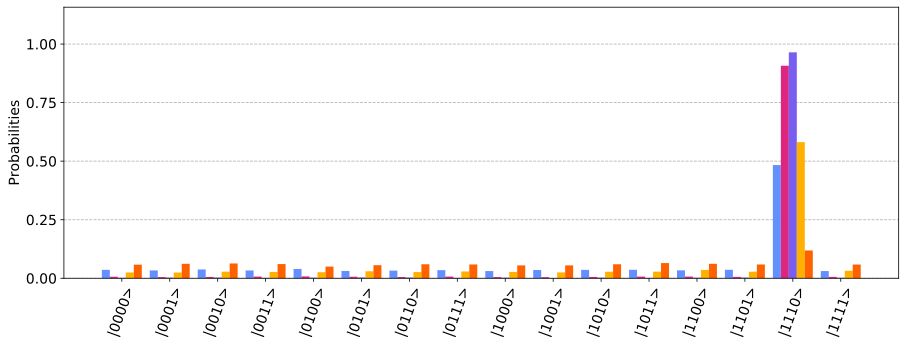

In [27]:
#Comparing 5 iterations
plot_histogram(l, bar_labels=False,figsize=(15, 5))

# Adding Noise
---

In [12]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
import math
simulator = QasmSimulator()

In [13]:
def noise_func(n,T1in,T2in):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(T1in, 10e3, n) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(T2in, 10e3, n)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(n)])

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                      for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                  for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                 thermal_relaxation_error(t1b, t2b, time_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(n):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(n):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

    #print(noise_thermal)
    return noise_thermal

In [33]:
k = 3 
inc_k = len(bin(k)[2:])
incg = inc(inc_k).to_gate()
incgc = incg.control()
rev = incgc.inverse()

2


In [14]:
l = [] #a list to store different number of iterations results
data = []
ss = []
noise_thermal = None
for i in range(1,6):
    qc,nodes_qubits,edge_anc,edge_flag,node_anc,node_flag,ancilla,neg_base,class_bits,tri_flag = grover(i,n_nodes)
    qc.measure(nodes_qubits,class_bits)
    #printing measurements results
    if noise_thermal is None:
        T1 = 500e3
        T2 = 500e3
        noise_thermal = noise_func(len(qc.qubits),T1,T2)
    ex = execute(qc, simulator, basis_gates=noise_thermal.basis_gates, noise_model=noise_thermal)
    res = ex.result()
    M = res.get_counts(qc)
    s = oq.Measurement(qc,shots=5000)   
    ss.append(M)
    print(M)
    pattern = "\d+\|\d+\>"
    res = re.findall(pattern,s)
    dct = {}
    for item in res:
        if item[item.index("|"):] not in dct.keys():
            dct[item[item.index("|"):]] = int(item[:item.index("|")]) 
        else:
            dct[item[item.index("|"):]] += int(item[:item.index("|")]) 
    l.append(dct)

{'0 0101': 41, '0 1111': 44, '0 0000': 40, '0 1001': 39, '0 0111': 383, '0 1100': 62, '0 1101': 46, '0 1011': 58, '0 0001': 39, '0 0010': 34, '0 1010': 32, '0 0100': 33, '0 0110': 47, '0 1110': 34, '0 1000': 38, '0 0011': 54}
{'0 0101': 26, '0 1111': 32, '0 0000': 19, '0 1001': 19, '0 0111': 662, '0 1100': 32, '0 1101': 36, '0 1011': 25, '0 0001': 25, '0 0010': 21, '0 1010': 19, '0 0100': 13, '0 0110': 27, '0 1110': 23, '0 1000': 21, '0 0011': 24}
{'0 0101': 33, '0 1111': 24, '0 0000': 22, '0 1001': 23, '0 0111': 637, '0 1100': 37, '0 1101': 25, '0 1011': 35, '0 0001': 24, '0 0010': 14, '0 1010': 17, '0 0100': 15, '0 0110': 28, '0 1110': 23, '0 1000': 14, '0 0011': 53}
{'0 0101': 54, '0 1111': 37, '0 0000': 38, '0 1001': 42, '0 0111': 415, '0 1100': 50, '0 1101': 54, '0 1011': 29, '0 0001': 42, '0 0010': 41, '0 1010': 38, '0 0100': 28, '0 0110': 48, '0 1110': 34, '0 1000': 29, '0 0011': 45}
{'0 0101': 51, '0 1111': 66, '0 0000': 50, '0 1001': 48, '0 0111': 241, '0 1100': 55, '0 1101': 

In [15]:
h = []
for item in ss:
    test_dict = {}
    for key in item.keys():
        k = '|'+key[2:][::-1]+'>'
        test_dict[k]= item[key]
    h.append(test_dict)
print(h) 

[{'|1010>': 41, '|1111>': 44, '|0000>': 40, '|1001>': 39, '|1110>': 383, '|0011>': 62, '|1011>': 46, '|1101>': 58, '|1000>': 39, '|0100>': 34, '|0101>': 32, '|0010>': 33, '|0110>': 47, '|0111>': 34, '|0001>': 38, '|1100>': 54}, {'|1010>': 26, '|1111>': 32, '|0000>': 19, '|1001>': 19, '|1110>': 662, '|0011>': 32, '|1011>': 36, '|1101>': 25, '|1000>': 25, '|0100>': 21, '|0101>': 19, '|0010>': 13, '|0110>': 27, '|0111>': 23, '|0001>': 21, '|1100>': 24}, {'|1010>': 33, '|1111>': 24, '|0000>': 22, '|1001>': 23, '|1110>': 637, '|0011>': 37, '|1011>': 25, '|1101>': 35, '|1000>': 24, '|0100>': 14, '|0101>': 17, '|0010>': 15, '|0110>': 28, '|0111>': 23, '|0001>': 14, '|1100>': 53}, {'|1010>': 54, '|1111>': 37, '|0000>': 38, '|1001>': 42, '|1110>': 415, '|0011>': 50, '|1011>': 54, '|1101>': 29, '|1000>': 42, '|0100>': 41, '|0101>': 38, '|0010>': 28, '|0110>': 48, '|0111>': 34, '|0001>': 29, '|1100>': 45}, {'|1010>': 51, '|1111>': 66, '|0000>': 50, '|1001>': 48, '|1110>': 241, '|0011>': 55, '|101

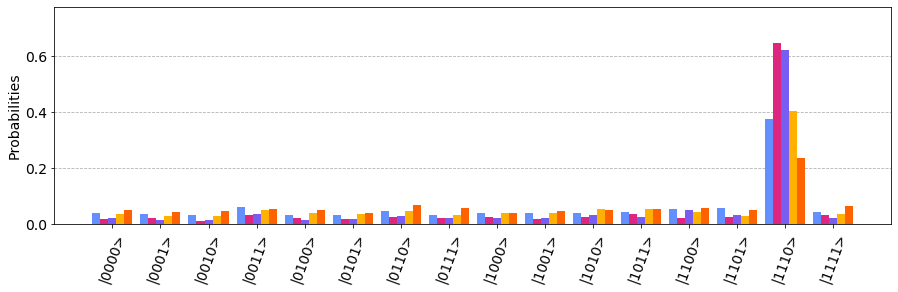

In [16]:
plot_histogram(h, bar_labels=False,figsize=(15, 4))